# Customer Churn Analysis Prediction - Python

Customer churn occurs when a customer stops using a company’s service lead to revenue loss. Analyzing churn helps businesses understand why customers leave and how to improve retention. High churn rates can affect revenue and business growth. By analyzing churn patterns businesses can take proactive steps to retain customers.

In this notebook we will explore the Telco Customer Churn dataset to predict churn effectively.

## 1. Importing Libraries and Dataset

### Loading the Dataset


We start by importing the necessary Python libraries and loading the Telco Customer Churn dataset. This dataset contains various customer details such as service plans, usage behavior and churn status.

In [1]:
import numpy as np
import pandas as pd


dataset = pd.read_csv('Telco-Customer-Churn.csv')

dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Understanding the Dataset

To gain insights into the dataset we first check for missing values and understand its structure. The dataset includes features such as:

In [2]:
print(dataset.isnull().sum())
print(dataset.describe())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


* tenure – The number of months a customer has stayed with the company.
* InternetService – The type of internet service the customer has DSL, Fiber optic or None.
* PaymentMethod– The method the customer uses for payments.
* Churn – The target variable i.e Yes for customer churned and No for customer stayed.

### Analyzing Churn Distribution

We check the number of churners and non-churners to understand the balance of the dataset.

Churn
No     5174
Yes    1869
Name: count, dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22532\2545296422.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=dataset, palette='coolwarm')


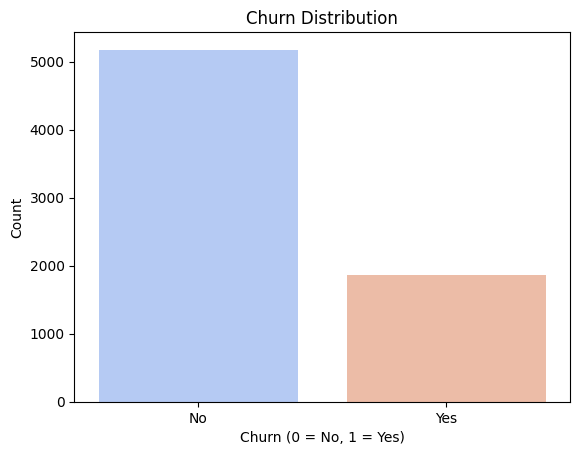

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

print(dataset['Churn'].value_counts())
sns.countplot(x='Churn', data=dataset, palette='coolwarm')
plt.title('Churn Distribution')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

## 2. Data Preprocessing

### Handling Missing and Incorrect Values

Before processing we ensure that all numerical columns contain valid values. The TotalCharges column sometimes has empty spaces which need to be converted to numerical values.

* **pd.to_numeric(dataset['TotalCharges'], errors='coerce')** converts the TotalCharges column to numerical format. If any value is not convertible (e.g., empty spaces), it replaces it with NaN.
* **.fillna(dataset['TotalCharges'].median(), inplace=True)** replaces missing values (NaN) with the median of the column to maintain consistency in numerical values.

In [4]:
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')
dataset['TotalCharges'].fillna(dataset['TotalCharges'].median(), inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22532\266048525.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['TotalCharges'].fillna(dataset['TotalCharges'].median(), inplace=True)


### Handling Categorical Variables

Some features like State, International Plan and Voice Mail Plan are categorical and must be converted into numerical values for model training.

* **LabelEncoder()** converts categorical values into numerical form. Each unique category is assigned a numeric label.
* The loop iterates through each categorical column and applies **fit_transform()** to encode categorical variables into numbers.

In [5]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
for col in categorical_cols:
    dataset[col] = labelencoder.fit_transform(dataset[col])

### Feature Selection and Splitting Data

We separate the features (X) and target variable (y) and split the dataset into training and testing sets.

* **X = dataset.drop(['customerID', 'Churn'], axis=1)** removes the customerID (irrelevant for prediction) and Churn column (target variable).
* **y = dataset['Churn']** defines y as the target variable, which we want to predict.
* **train_test_split()** splits data into 80% training and 20% testing for model evaluation.

In [6]:
from sklearn.model_selection import train_test_split

X = dataset.drop(['customerID', 'Churn'], axis=1)
y = dataset['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Feature Scaling

Since features are on different scales we apply standardization to improve model performance. It prevents models from being biased toward larger numerical values and improves convergence speed in optimization algorithms like gradient descent

* **StandardScaler():** Standardizes data by transforming it to have a mean of 0 and a standard deviation of 1 ensuring all features are on a similar scale.
* **fit_transform(X_train):** Fits the scaler to the training data and transforms it.
* **transform(X_test):** Transforms the test data using the same scaling parameters.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3. Model Training and Prediction

For training our model we use Random Forest Classifier. It is an ensemble learning method that combines the results of multiple decision trees to make a final prediction.

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

## 4. Model Evaluation

### Accuracy Score

To measure model performance we calculate accuracy using the accuracy_score function.

In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.79


### Confusion Matrix and Performance Metrics

We evaluate precision, recall and accuracy using a confusion matrix.

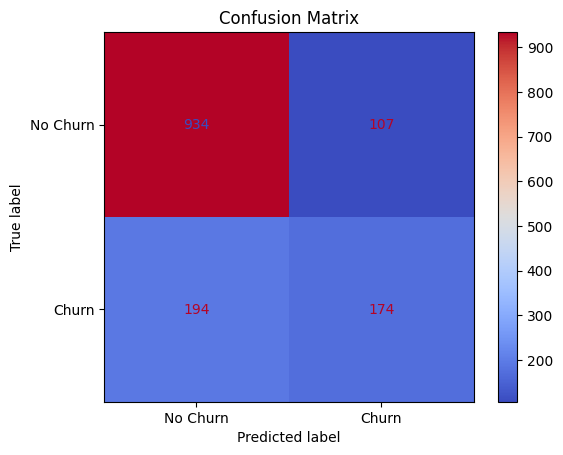

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap="coolwarm")
plt.title('Confusion Matrix')
plt.show()

Confusion matrix shows how well the model predicts customer churn. It correctly identifies 934 non-churners and 174 churners. However 107 non-churners are wrongly classified as churners and 194 churners are missed. The high number of missed churners suggests the model may need further tuning.